In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))

In [2]:
# Set themes
file_extensions <- c(".png", ".pdf")

plot_theme <- theme(
    title = element_text(size = 9),
    axis.title = element_text(size = 9),
    legend.text = element_text(size = 7),
    legend.title = element_text(size = 9),
    legend.key.size = unit(0.5, "cm"),
    strip.text = element_text(size = 10),
    strip.background = element_rect(colour="black", fill="#fdfff4")
)

In [3]:
# Load L2 distances per MOA
cp_file <- file.path("data", "MOA_LSA_metrics.tsv")
cp_df <- readr::read_tsv(cp_file)

cp_df$model <- factor(
    cp_df$model,
    levels = c("Vanilla", "Beta", "MMD", "PCA", "Complete")
)

head(cp_df)

Rows: 840 Columns: 4

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): MOA, model, metric
dbl (1): zscore


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



MOA,model,zscore,metric
<chr>,<fct>,<dbl>,<chr>
NFkB pathway inhibitor|proteasome inhibitor,Vanilla,-3.153561,L2 distance
NFkB pathway inhibitor|proteasome inhibitor,Beta,-3.143671,L2 distance
NFkB pathway inhibitor|proteasome inhibitor,MMD,-3.153877,L2 distance
NFkB pathway inhibitor|proteasome inhibitor,PCA,-2.970405,L2 distance
NFkB pathway inhibitor|proteasome inhibitor,Complete,-2.806738,L2 distance
dopamine receptor antagonist|serotonin receptor antagonist,Vanilla,-1.179638,L2 distance


In [4]:
# Compare performance means across architectures
cp_mean_df <- cp_df %>%
    dplyr::group_by(model, metric) %>%
    dplyr::mutate(
        model_mean = round(mean(zscore), 2)
    ) %>%
    dplyr::select(model, metric, model_mean) %>%
    dplyr::distinct()

cp_mean_df

model,metric,model_mean
<fct>,<chr>,<dbl>
Vanilla,L2 distance,-0.34
Beta,L2 distance,-0.23
MMD,L2 distance,-0.42
PCA,L2 distance,-0.19
Complete,L2 distance,-0.09
Vanilla,Pearson correlation,0.21
Beta,Pearson correlation,0.17
MMD,Pearson correlation,0.42
PCA,Pearson correlation,0.17


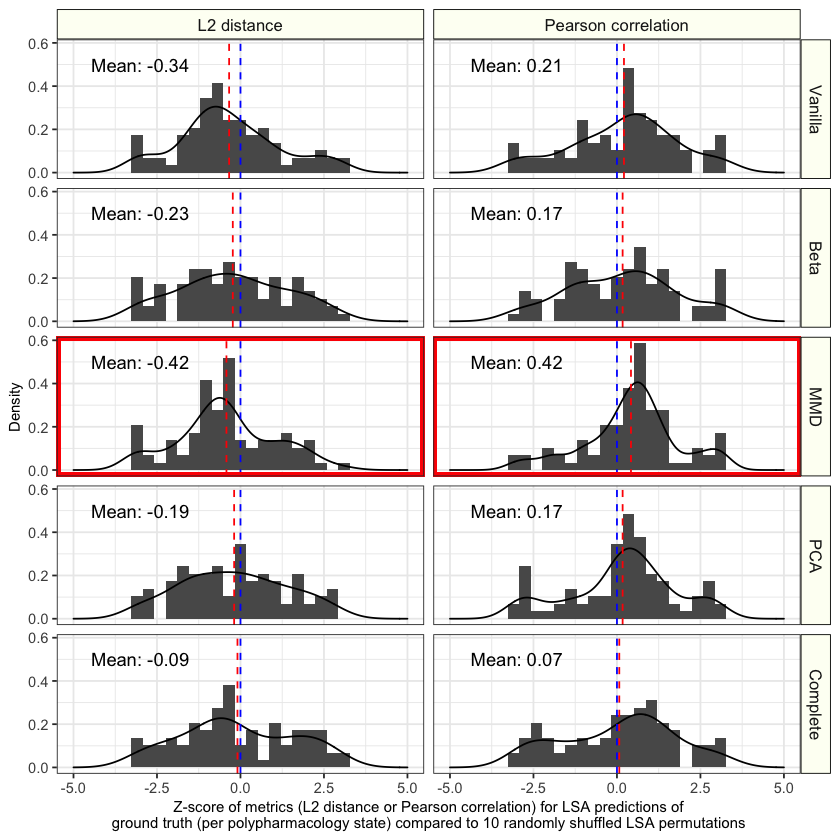

In [5]:
plot_gg <- (
    ggplot(cp_df, aes(x=zscore))
    + geom_histogram(aes(y = ..density..), bins = 30)
    + geom_density()
    + geom_text(
        data=cp_mean_df,
        aes(x = -3, y = 0.5, label = paste0("Mean: ", model_mean))
    )
    + geom_vline(
        data=cp_mean_df,
        aes(xintercept = model_mean),
        color = "red",
        linetype="dashed"
    )
    + geom_vline(
        xintercept = 0,
        linetype = "dashed",
        color = "blue"
    )
    + facet_grid("model~metric")
    + theme_bw()
    + xlim(c(-5, 5))
    + plot_theme
    + geom_rect(
        data = cp_df %>%
            dplyr::filter(model == "MMD"),
        fill = NA,
        alpha = 1,
        color = "red",
        linetype = "solid",
        size = 2,
        xmin = -Inf,
        xmax = Inf,
        ymin = -Inf,
        ymax = Inf
    )
    + ylab("Density")
    + xlab("Z-score of metrics (L2 distance or Pearson correlation) for LSA predictions of\nground truth (per polypharmacology state) compared to 10 randomly shuffled LSA permutations")
    
)
plot_gg

In [6]:
# Save figure
output_file_base <- file.path("output", "sup_fig_lsa_metrics")
for (file_extension in file_extensions) {
    output_file <- paste0(output_file_base, file_extension)
    ggplot2::ggsave(output_file, plot_gg, dpi = 500, width = 8, height = 8)
}